# Ex.3 | Deep Learning Course | Eyal Betzalel ID 201511193

GAN
---
This exercise show how one can use GAN in order to generate new photos of numbers digits by mimik mnisit data set.  

Import packages:

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Import Mnist dataset:

In [0]:
bs = 32

# MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

Create the generator and discriminator networks:

In [0]:

class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

**Leaky ReLU**

A "dead" ReLU always outputs the same value (zero as it happens, but that is not important) for any input. Probably this is arrived at by learning a large negative bias term for its weights.

In turn, that means that it takes no role in discriminating between inputs. For classification, you could visualise this as a decision plane outside of all possible input data.

Once a ReLU ends up in this state, it is unlikely to recover, because the function gradient at 0 is also 0, so gradient descent learning will not alter the weights. "Leaky" ReLUs with a small positive gradient for negative inputs (y=0.02x when x < 0 in my network case) are one attempt to address this issue and give a chance to recover.


In [4]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


The input for the generator is noise vector (size = 100) and the output is new mnist generated picture (size = 784):

In [5]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

The input for the discriminator is mnist picture vector (size = 784) and the output is binary classification - True or False (size = 1):

In [6]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [0]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

**BCELoss**

Creates a criterion that measures the Binary Cross Entropy between the target and the output.

### Train the discriminator

In [0]:
def D_train(x):
    
    D.zero_grad()

    # train discriminator on real images:

    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1) # torch.ones(bs, 1) = labels for true
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))
    # put the output from the generator in the D:
    D_output = D(x_fake) 
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

### Train the generator

In [0]:
def G_train(x):
    
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [0]:
import matplotlib.pyplot as plt
import numpy as np

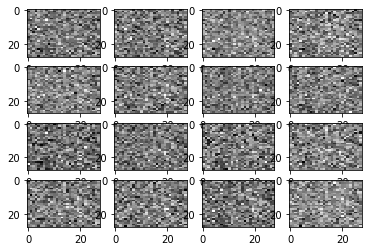

[1/70]: loss_d: 1.138, loss_g: 1.848


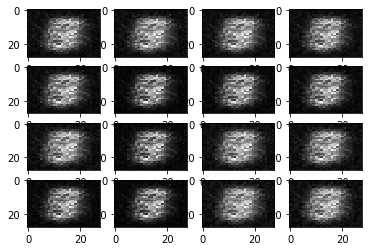

[2/70]: loss_d: 0.802, loss_g: 1.998


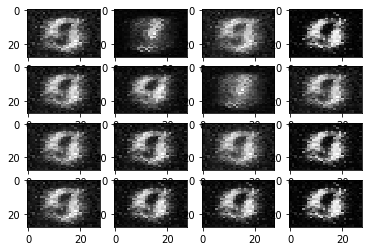

[3/70]: loss_d: 0.725, loss_g: 1.959


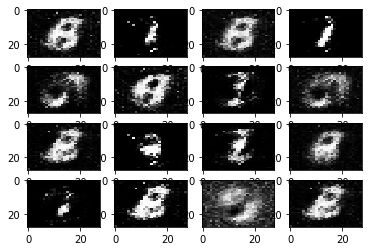

[4/70]: loss_d: 0.756, loss_g: 1.924


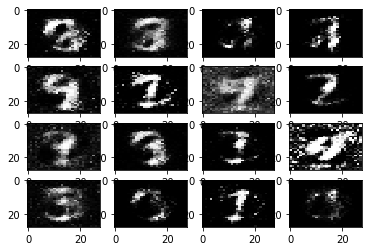

[5/70]: loss_d: 0.915, loss_g: 1.545


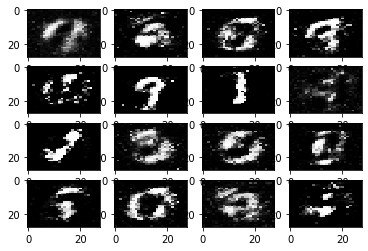

[6/70]: loss_d: 0.937, loss_g: 1.502


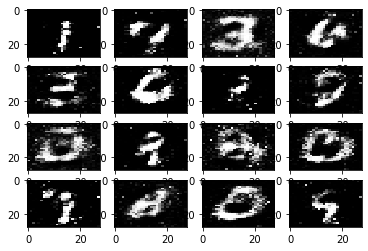

[7/70]: loss_d: 0.994, loss_g: 1.396


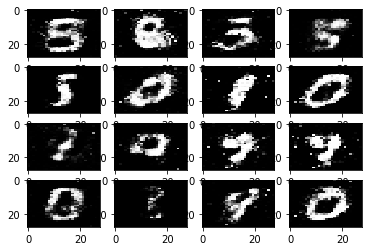

[8/70]: loss_d: 1.042, loss_g: 1.299


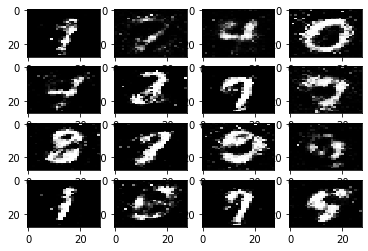

[9/70]: loss_d: 1.033, loss_g: 1.306


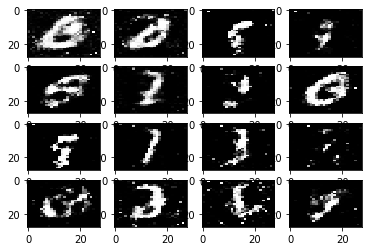

[10/70]: loss_d: 1.068, loss_g: 1.247


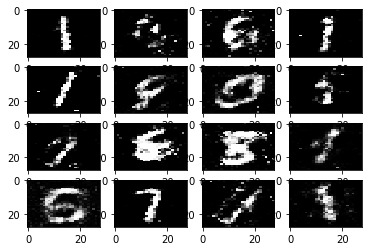

[11/70]: loss_d: 1.086, loss_g: 1.221


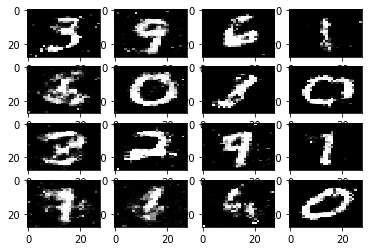

[12/70]: loss_d: 1.096, loss_g: 1.187


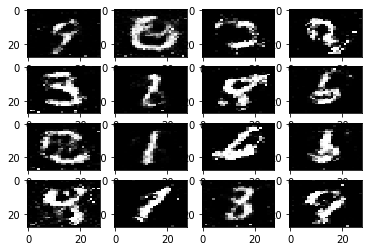

[13/70]: loss_d: 1.140, loss_g: 1.115


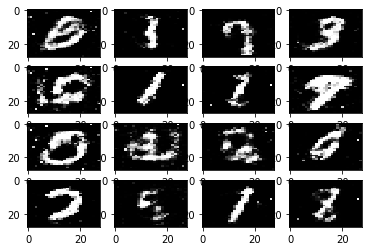

[14/70]: loss_d: 1.157, loss_g: 1.091


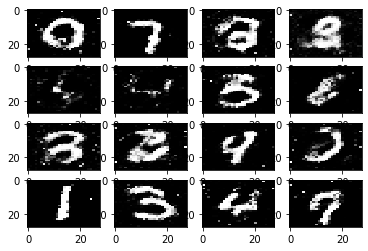

[15/70]: loss_d: 1.156, loss_g: 1.091


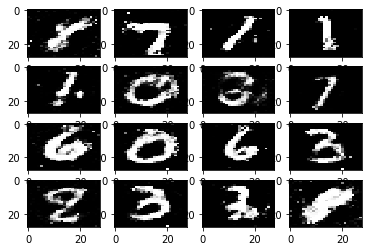

[16/70]: loss_d: 1.183, loss_g: 1.047


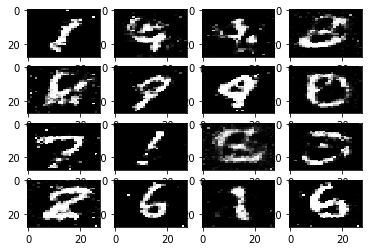

[17/70]: loss_d: 1.186, loss_g: 1.035


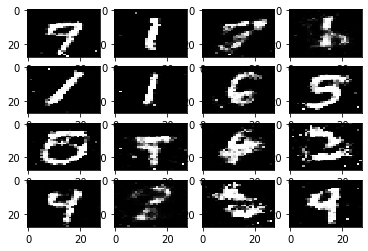

[18/70]: loss_d: 1.205, loss_g: 0.999


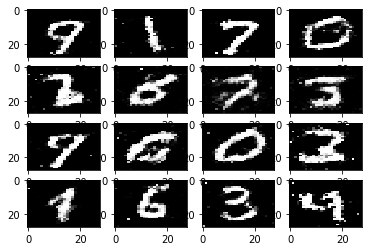

[19/70]: loss_d: 1.212, loss_g: 0.989


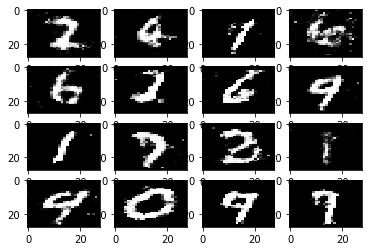

[20/70]: loss_d: 1.231, loss_g: 0.962


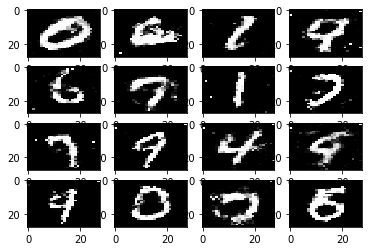

[21/70]: loss_d: 1.229, loss_g: 0.963


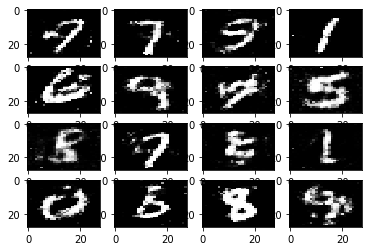

[22/70]: loss_d: 1.241, loss_g: 0.937


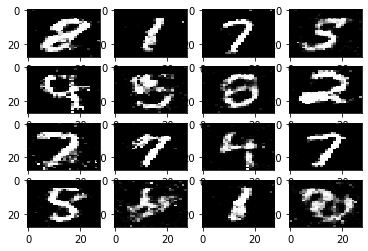

[23/70]: loss_d: 1.243, loss_g: 0.942


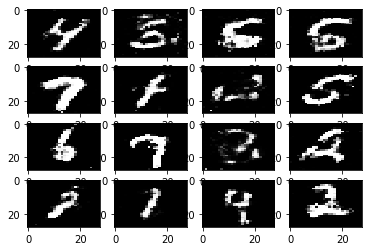

[24/70]: loss_d: 1.249, loss_g: 0.929


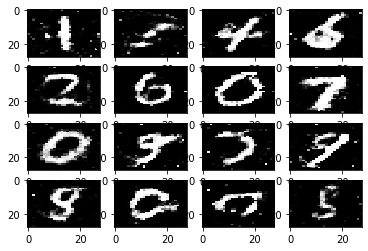

[25/70]: loss_d: 1.252, loss_g: 0.927


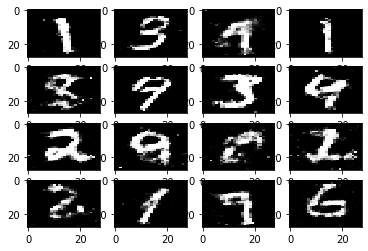

[26/70]: loss_d: 1.258, loss_g: 0.916


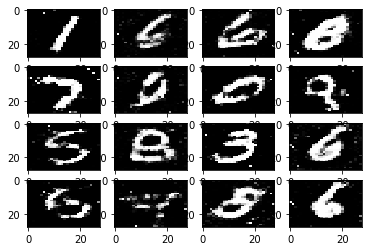

[27/70]: loss_d: 1.264, loss_g: 0.907


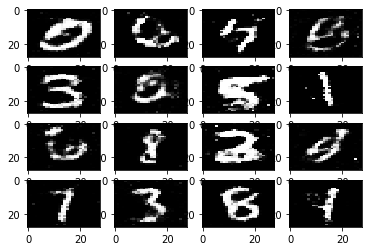

[28/70]: loss_d: 1.260, loss_g: 0.908


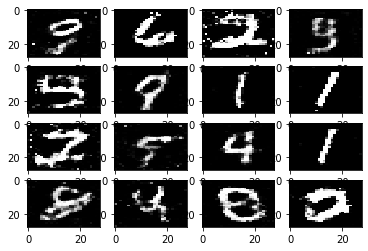

[29/70]: loss_d: 1.265, loss_g: 0.904


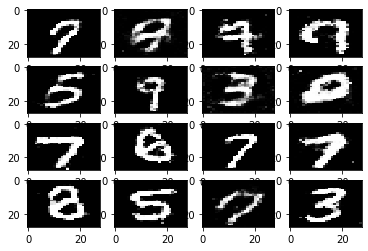

[30/70]: loss_d: 1.267, loss_g: 0.898


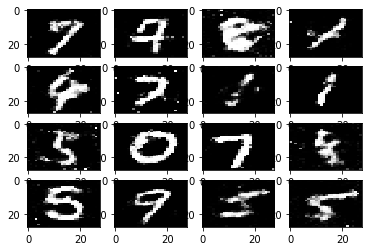

[31/70]: loss_d: 1.271, loss_g: 0.893


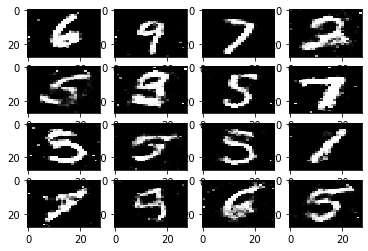

[32/70]: loss_d: 1.273, loss_g: 0.891


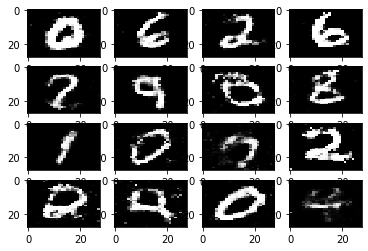

[33/70]: loss_d: 1.271, loss_g: 0.896


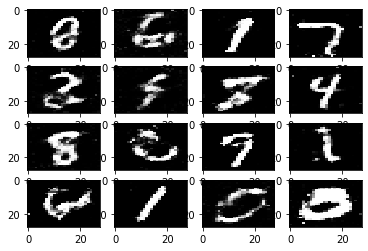

[34/70]: loss_d: 1.278, loss_g: 0.889


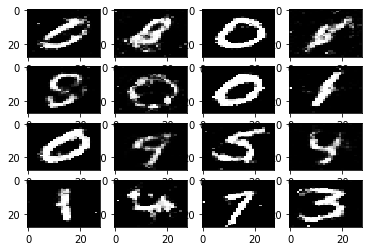

[35/70]: loss_d: 1.274, loss_g: 0.888


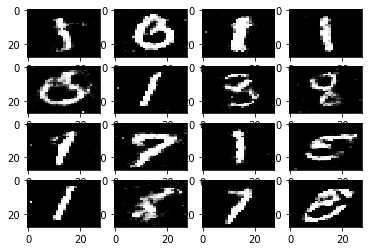

[36/70]: loss_d: 1.282, loss_g: 0.881


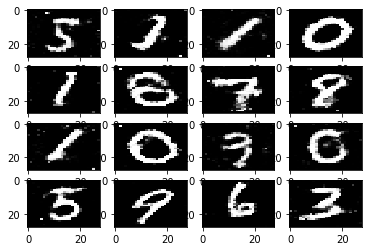

[37/70]: loss_d: 1.285, loss_g: 0.878


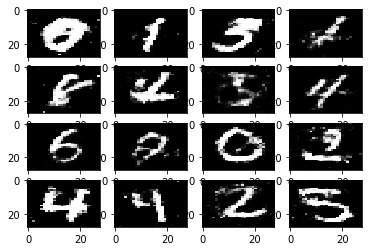

[38/70]: loss_d: 1.279, loss_g: 0.883


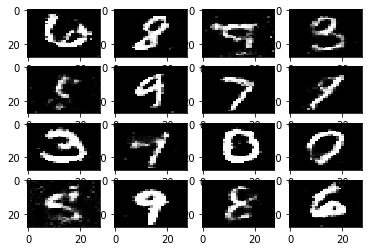

[39/70]: loss_d: 1.280, loss_g: 0.883


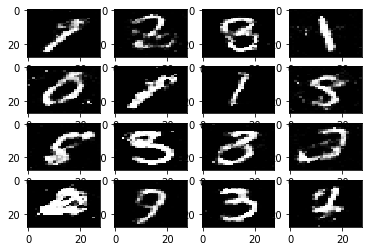

[40/70]: loss_d: 1.283, loss_g: 0.870


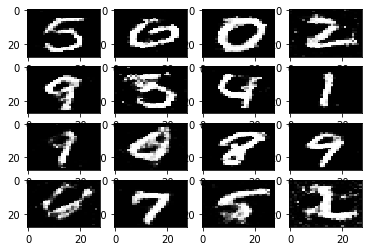

[41/70]: loss_d: 1.288, loss_g: 0.868


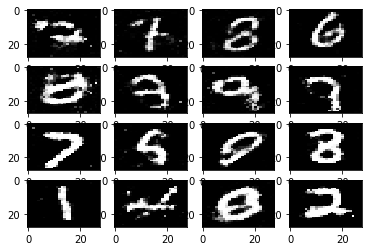

[42/70]: loss_d: 1.284, loss_g: 0.874


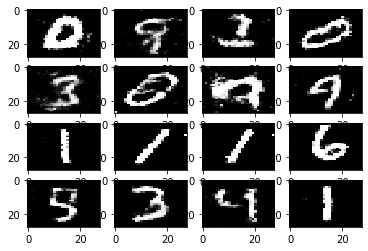

[43/70]: loss_d: 1.291, loss_g: 0.863


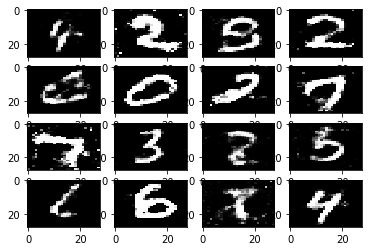

[44/70]: loss_d: 1.283, loss_g: 0.875


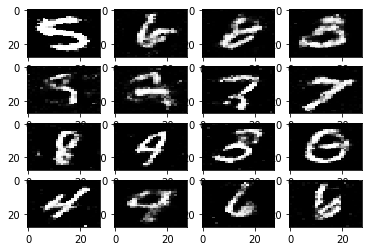

[45/70]: loss_d: 1.291, loss_g: 0.865


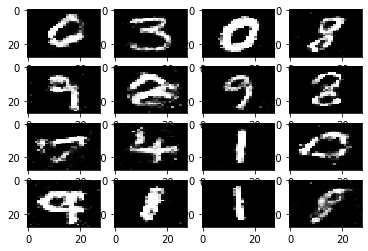

[46/70]: loss_d: 1.294, loss_g: 0.859


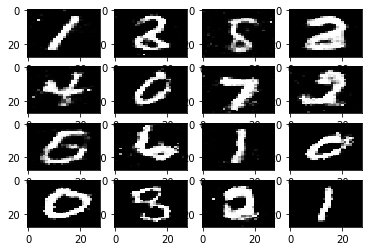

[47/70]: loss_d: 1.291, loss_g: 0.862


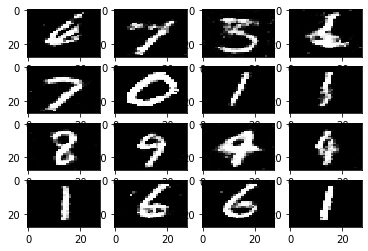

[48/70]: loss_d: 1.293, loss_g: 0.860


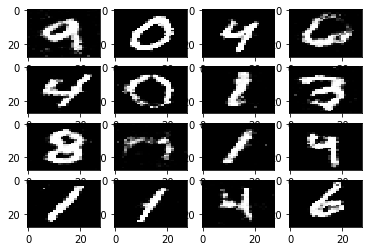

[49/70]: loss_d: 1.293, loss_g: 0.857


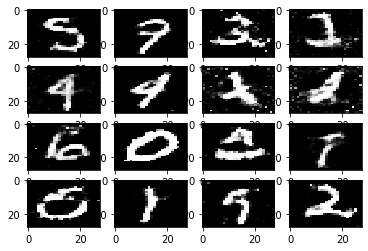

[50/70]: loss_d: 1.294, loss_g: 0.860


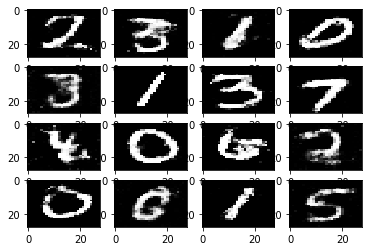

[51/70]: loss_d: 1.292, loss_g: 0.860


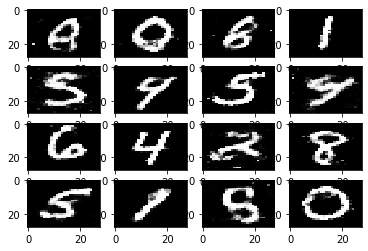

[52/70]: loss_d: 1.300, loss_g: 0.852


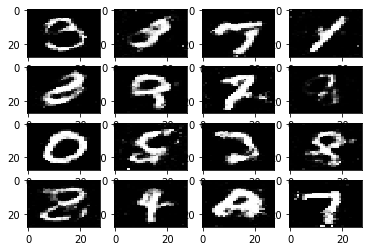

[53/70]: loss_d: 1.294, loss_g: 0.858


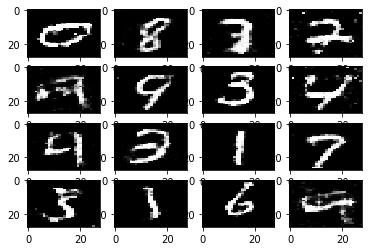

[54/70]: loss_d: 1.288, loss_g: 0.867


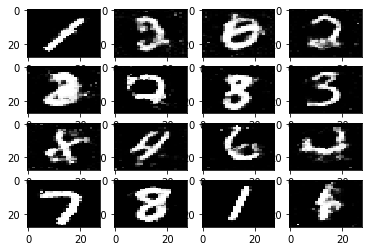

[55/70]: loss_d: 1.296, loss_g: 0.850


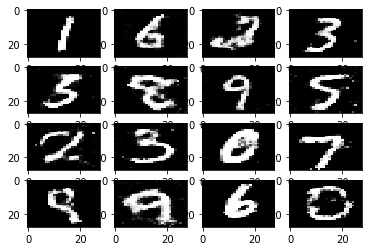

[56/70]: loss_d: 1.294, loss_g: 0.858


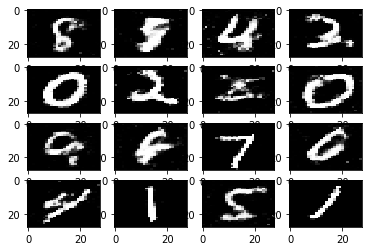

[57/70]: loss_d: 1.296, loss_g: 0.857


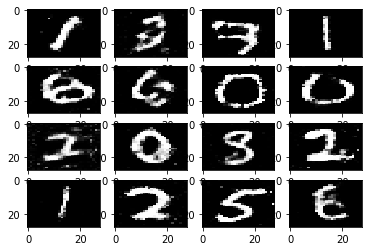

[58/70]: loss_d: 1.295, loss_g: 0.856


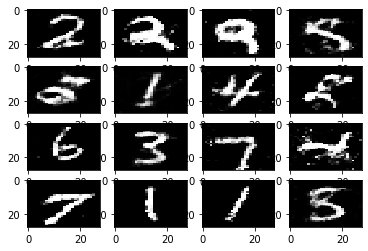

[59/70]: loss_d: 1.295, loss_g: 0.854


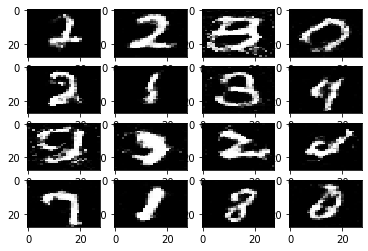

[60/70]: loss_d: 1.297, loss_g: 0.853


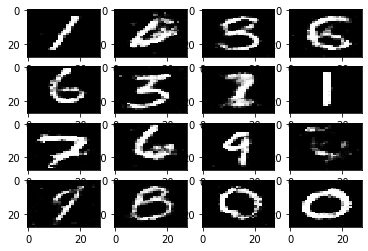

[61/70]: loss_d: 1.296, loss_g: 0.852


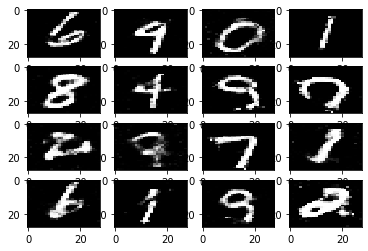

[62/70]: loss_d: 1.299, loss_g: 0.852


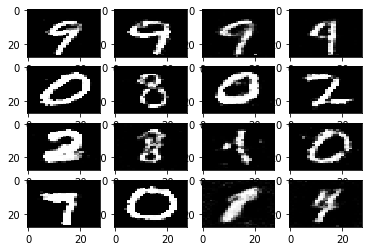

[63/70]: loss_d: 1.298, loss_g: 0.848


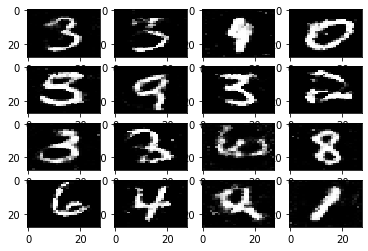

[64/70]: loss_d: 1.298, loss_g: 0.852


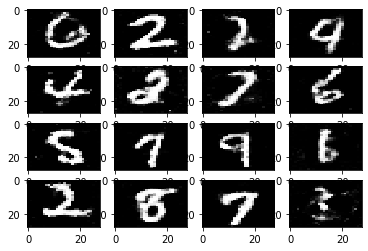

[65/70]: loss_d: 1.296, loss_g: 0.858


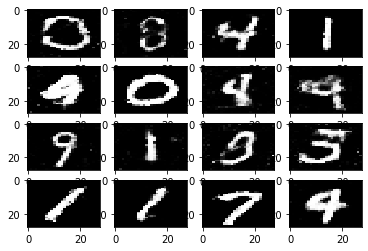

[66/70]: loss_d: 1.296, loss_g: 0.856


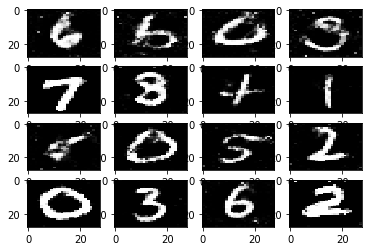

[67/70]: loss_d: 1.300, loss_g: 0.846


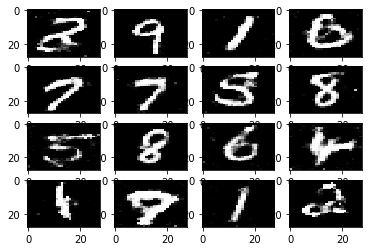

[68/70]: loss_d: 1.300, loss_g: 0.849


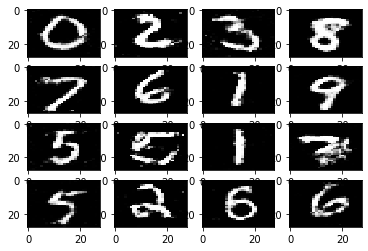

[69/70]: loss_d: 1.299, loss_g: 0.852


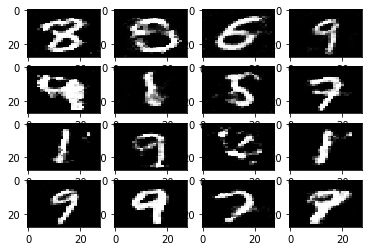

[70/70]: loss_d: 1.298, loss_g: 0.852


In [12]:
n_epoch = 70
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))
        # Plot output from generator while the network is learning:
        num_test_samples = 16
        test_noise = Variable(torch.randn(bs, z_dim).to(device))
        if (batch_idx) % 10000 == 0: 
            test_images =G(test_noise).cpu().data.numpy()
            test_images =np.squeeze(test_images.data)
            test_images = (test_images + 1) / 2.0
            # plot the generated samples
            for i in range(0,num_test_samples):
              plt.subplot(4, 4, 1 + i)
              plt.imshow(test_images[i].reshape((28, 28)), cmap='gray', aspect='auto')
        plt.show()

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

As we can see , at the begining of the learning process the Generator output was noise. as the process went on the output of the Generator became more and more similar to MNISIT dataset. at the end (after 70 epochs) - most of the Generator outputs look like real digits.  